# Определение возраста покупателей

**Описание проекта:**  
Супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Цель — определить возраст клиентов по изображению, чтобы анализировать покупки и контролировать продажу товаров с возрастными ограничениями.

**Цель проекта:**  
Построить модель, которая по фотографии определяет приблизительный возраст человека с метрикой качества **MAE < 8**.

**Задачи:**  
- Провести исследовательский анализ данных (EDA).  
- Подготовить изображения для обучения с помощью `ImageDataGenerator`.  
- Обучить сверточную нейронную сеть на основе **ResNet50**, предобученной на ImageNet.  
- Оценить качество модели на тестовой выборке.  

**Описание данных:**  
Данные взяты из набора **ChaLearn LAP (APPA-REAL)** и находятся в `/datasets/faces/`.  
- `labels.csv` — содержит `file_name` и `real_age`.  
- `/final_files/` — папка с изображениями лиц.  

## Исследовательский анализ данных

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Загрузка и первичное изучение данных
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())
print(labels.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None
          real_age
count  7591.000000
mean     31.201159
std      17.145060
min       1.000000
25%      20.000000
50%      29.000000
75%      41.000000
max     100.000000


**Вывод:**

- В таблице `labels.csv` содержится **7591 запись**.  
- Присутствуют две колонки:  
  - `file_name` — имя файла изображения;  
  - `real_age` — реальный возраст человека.  
- Пропущенных значений **нет**.  
- Возраст варьируется от **1 до 100 лет**, среднее значение — около **31 года**.  
- Большинство наблюдений сосредоточено в диапазоне **15–40 лет**.  

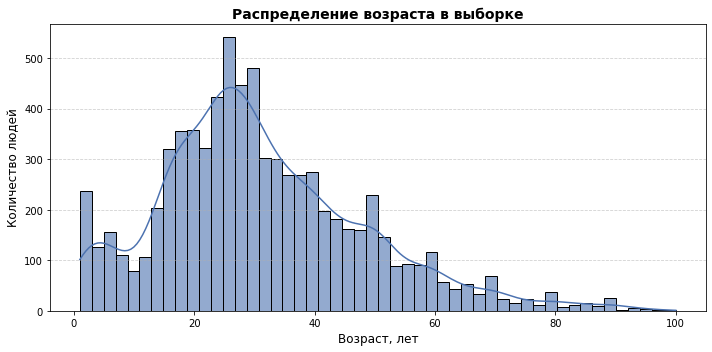

In [7]:
# Анализ распределения возрастов
plt.figure(figsize=(10, 5))
sns.histplot(labels['real_age'], bins=50, color='#4C72B0', edgecolor='black', alpha=0.6, kde=True)
plt.title('Распределение возраста в выборке', fontsize=14, fontweight='bold')
plt.xlabel('Возраст, лет', fontsize=12)
plt.ylabel('Количество людей', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Вывод:**

- В датасете представлены люди в возрасте от **1 до 100 лет**.  
- Наибольшее количество изображений приходится на возрастную группу **15–40 лет**.  
- После 40 лет наблюдается **постепенное снижение** числа примеров.  
- Распределение возраста не нормальное.

In [9]:
# Подготовка генератора изображений
datagen = ImageDataGenerator(rescale=1/255.)
flow = datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    class_mode='raw',
    batch_size=15,
    shuffle=True,
    seed=12345
)

Found 7591 validated image filenames.


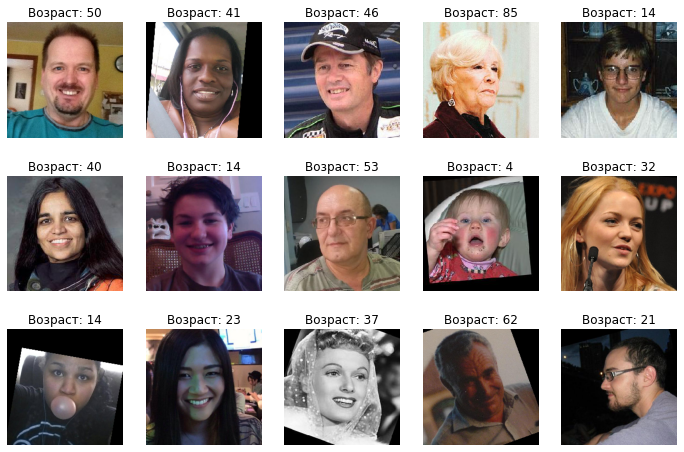

In [10]:
# Вывод примеров изображений
images, ages = next(flow)

plt.figure(figsize=(12,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.imshow(images[i])
    plt.title(f'Возраст: {int(ages[i])}')
    plt.axis('off')
plt.show()

Изображения успешно загружены — в выборке **7591 фото**. Примеры показывают людей разных возрастов, с различным освещением, фоном и ракурсом. Такое разнообразие данных положительно скажется на способности модели обобщать и определять возраст на новых изображениях.

## Обучение модели

В данном блоке определены функции для подготовки данных и обучения модели.  
Сначала данные загружаются из файла `labels.csv` и обрабатываются с помощью `ImageDataGenerator`,  
который выполняет нормализацию изображений и делит выборку на обучающую и валидационную части.  

Модель создаётся на основе предобученной архитектуры **ResNet50**, обученной на датасете ImageNet.  
К базовой сети добавлены слои `GlobalAveragePooling2D`, `Dropout` и выходной `Dense` с одним нейроном для предсказания возраста.  

Функция `train_model()` запускает процесс обучения модели и оценивает её качество по метрике **MAE** (средняя абсолютная ошибка),  
которая является ключевой для данной задачи регрессии.

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

RANDOM_STATE = 42

def load_data(path, subset):
    # Загрузка данных и создание генератора изображений
    labels = pd.read_csv(path + '/labels.csv')
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    generator = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset=subset,
        seed=RANDOM_STATE
    )
    return generator


def load_train(path):
    # Генератор обучающей выборки
    return load_data(path, 'training')


def load_test(path):
    # Генератор валидационной выборки
    return load_data(path, 'validation')


def create_model(input_shape):
    # Модель на основе предобученной ResNet50
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    backbone.trainable = True

    model = Sequential([
        backbone,
        GlobalAveragePooling2D(),
        Dropout(0.4, seed=RANDOM_STATE),
        Dense(1, activation='relu')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])
    return model


def train_model(model, train_data, test_data,
                batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    # Обучение модели
    model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2
    )
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 63s - loss: 257.6264 - mae: 11.4799 - val_loss: 1030.3669 - val_mae: 27.3172
Epoch 2/10
178/178 - 38s - loss: 65.6374 - mae: 6.1078 - val_loss: 1019.7246 - val_mae: 27.1279
Epoch 3/10
178/178 - 38s - loss: 34.8199 - mae: 4.5247 - val_loss: 652.2930 - val_mae: 20.6214
Epoch 4/10
178/178 - 39s - loss: 24.2784 - mae: 3.7788 - val_loss: 120.0886 - val_mae: 8.3663
Epoch 5/10
178/178 - 38s - loss: 19.8155 - mae: 3.4172 - val_loss: 80.7164 - val_mae: 6.7390
Epoch 6/10
178/178 - 38s - loss: 17.1450 - mae: 3.1916 - val_loss: 89.6702 - val_mae: 7.3786
Epoch 7/10
178/178 - 38s - loss: 14.1454 - mae: 2.8918 - val_loss: 74.6760 - val_mae: 6.4780
Epoch 8/10
178/178 - 38s - loss: 13.2312 - mae: 2.7684 - val_loss: 80.4811 - val_mae: 6.6538
Epoch 9/10
178/178 - 38s - loss: 11.9366 - mae: 2.6049 - val_loss: 67.4610 - val_mae: 6.2186
Epoch 10/10
178/178 - 38s - loss: 10.7935 - mae: 2.4740 - val_loss: 65.6951 - val_mae: 6.1321
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.6951 - mae: 6.1321
```

## Анализ обученной модели

Обученная модель на основе **ResNet50** показала хороший результат.  
На финальной эпохе метрика **MAE** на тестовой выборке составила примерно **6.13**,  
что удовлетворяет целевому условию (MAE < 8).  

График обучения демонстрирует быстрое снижение ошибки на первых эпохах  
и стабилизацию показателей после 6–7 эпох, что говорит об эффективном обучении без явного переобучения.  

Модель способна достаточно точно определять возраст по фотографиям,  
несмотря на разнообразие ракурсов, освещения и выражений лиц.